In [2]:
# importing necessary libraries
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop

# Task A.1 Data Preparation (Face extraction)

## Extracting only the face region from the dataset (USING HAAR CASCADE)

In [3]:
import glob

## Extracting face region from men dataset

In [154]:
# Select the path
path = "dataset/training/men"
img_number = 1  # Start an iterator for image number.
no_face = 0  # to count the total number of exceptions thrown on the images
undetected_images = []   # list to store those images that Haar Cascade was not able to detec faces of!

# Load the pre-trained Haar Cascade classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Extracting at most one face from each image to be used for training
for file in glob.glob(path + "/*.jpg"):
    print(file)  # Just stop here to see all file names printed
    img = cv2.imread(file, 1)  # Now, we can read each file since we have the full path

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    # faces = face_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=5)
    # faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    try:
        # Process only the first detected face
        x, y, w, h = faces[0]
        roi_color = img[y:y + h, x:x + w]
        resized = cv2.resize(roi_color, (128, 128))
        cv2.imwrite("extracted/men/" + str(img_number) + ".jpg", resized)
        print(f"Saved face: {img_number}.jpg")
        img_number += 1
    except IndexError:
        print(f"No faces detected in image: {file}")
        undetected_images.append(file)
        no_face += 1


dataset/training/men\01_01_01_00_0001.jpg
Saved face: 1.jpg
dataset/training/men\01_01_02_00_0003.jpg
Saved face: 2.jpg
dataset/training/men\01_01_03_00_0055.jpg
Saved face: 3.jpg
dataset/training/men\01_01_07_00_0001.jpg
Saved face: 4.jpg
dataset/training/men\01_01_09_00_0003.jpg
Saved face: 5.jpg
dataset/training/men\01_01_10_00_0001.jpg
Saved face: 6.jpg
dataset/training/men\01_01_10_00_0005.jpg
No faces detected in image: dataset/training/men\01_01_10_00_0005.jpg
dataset/training/men\01_01_12_00_0005.jpg
No faces detected in image: dataset/training/men\01_01_12_00_0005.jpg
dataset/training/men\01_01_14_00_0005.jpg
Saved face: 7.jpg
dataset/training/men\01_01_15_00_0007.jpg
Saved face: 8.jpg
dataset/training/men\01_01_16_00_0007.jpg
Saved face: 9.jpg
dataset/training/men\01_01_17_00_0013.jpg
Saved face: 10.jpg
dataset/training/men\01_01_19_00_0005.jpg
Saved face: 11.jpg
dataset/training/men\01_01_19_00_0007.jpg
Saved face: 12.jpg
dataset/training/men\01_01_20_00_0005.jpg
Saved face:

### Displaying the images after the completion of face extraction with Haar Cascade


Displaying generated face images :


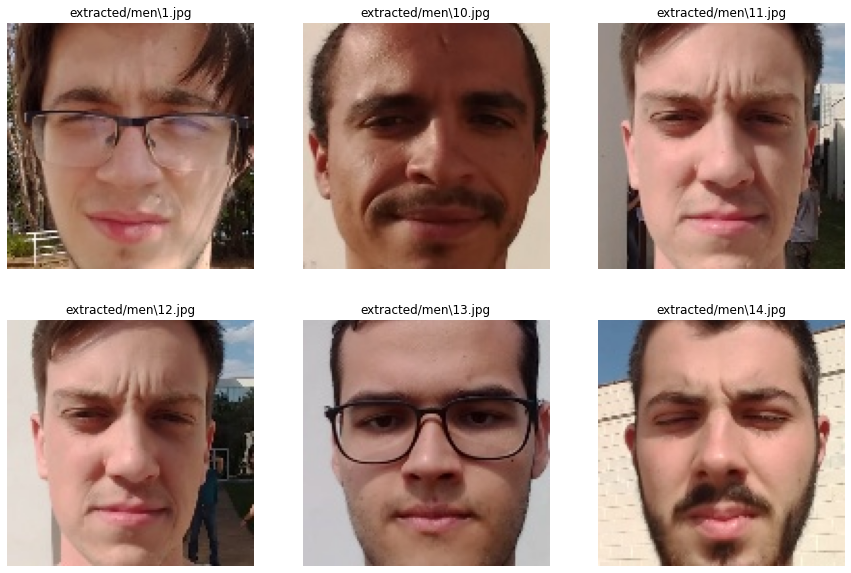

In [147]:
path = "extracted/men"

generated_images = glob.glob(path + "/*.jpg")[:6]  # Display the first 6 images

# Display generated face images in a grid
print("\nDisplaying generated face images :")

num_columns = 3  #colunmn size
num_images = len(generated_images)
num_rows = (num_images + num_columns - 1) // num_columns

# Create a subplot grid
fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))

# Flatten the subplot grid for easier indexing
axs = axs.flatten()

for i, image_path in enumerate(generated_images):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV reads images in BGR, convert to RGB for matplotlib
    axs[i].imshow(img)
    axs[i].set_title(image_path)
    axs[i].axis('off')

plt.show()

## Displaying those images that were not detected by Haar Cascade

In [163]:
# print total number of images that went undetected by Haar Cascade
print(f"Total number of images with no faces detected: {no_face}")
# undetected_images

Total number of images with no faces detected: 7



Displaying images with no detected faces:


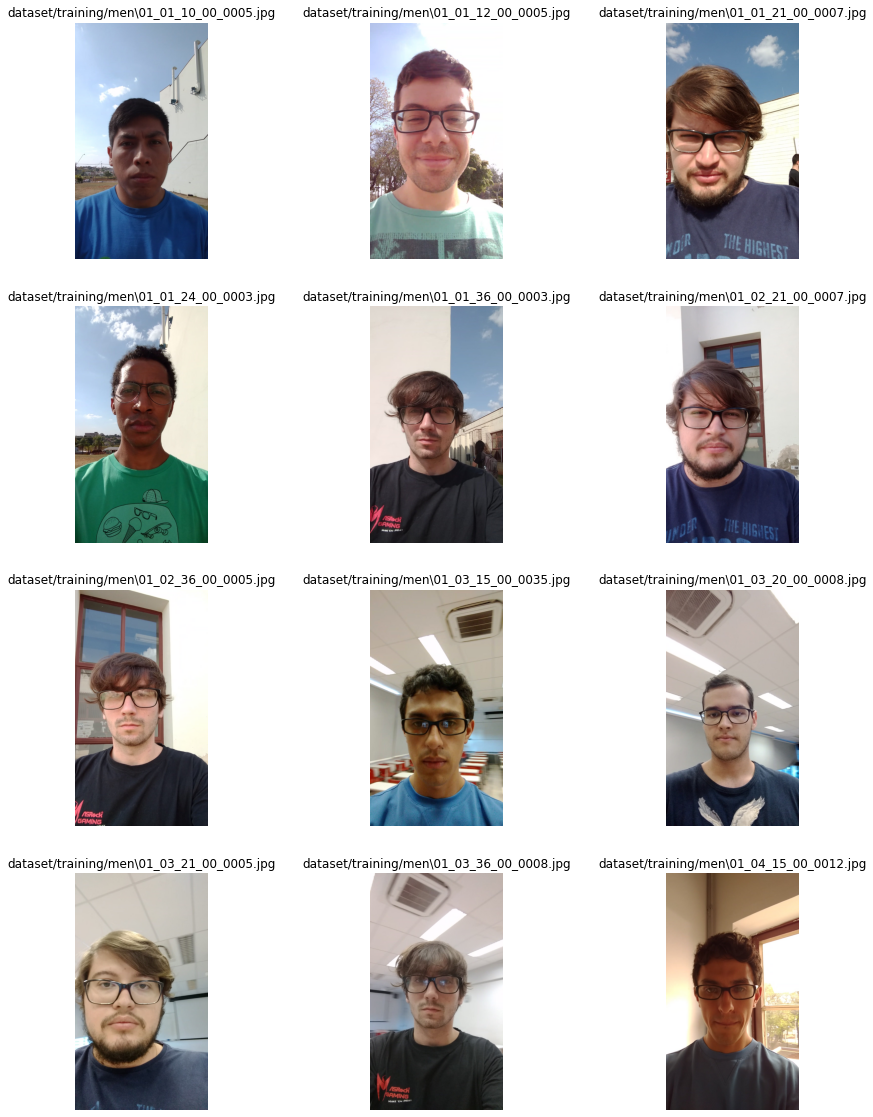

In [149]:
# Displaying images that Haar Cascade couldn't detect faces of.
print("\nDisplaying images with no detected faces:")

num_columns = 3  #set the column size of grid
num_images = len(undetected_images)
num_rows = (num_images + num_columns - 1) // num_columns

# Create a subplot grid
fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))

# Flatten the subplot grid for easier indexing
axs = axs.flatten()

for i, image_path in enumerate(undetected_images):
    img = mpimg.imread(image_path)
    axs[i].imshow(img)
    axs[i].set_title(image_path)
    axs[i].axis('off')

# Hide any empty subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.show()


## Inference from men face data extraction/preparation

1. After experimenting with numerous combinations of `scaleFactor` and `minNeighbors` values, the best results that HaarCascade was able to provide were with scaleFactor = 1.3 and minNeighbors = 5. Out of 100 images, it successfully detected faces in 88 images, leaving 12 images undetected by HaarCascade. 
2. While missing only 12 images might not significantly impact the analysis in a larger dataset, ....
given our small dataset with only 100 men images which is still a 12% of the entire dataset so it would not be feasible to drop these images.
3. Under close inspection, we can see from the above grid that the images that Haar Cascade could not identify as faces are those images which either have a very bright contrast, or images which are not separate from the background, or low-light images, or those where the face overlaps with the edges of the image (i.e., face not in the middle).

## Addressing this problem !!!!

The images that Haar Cascade could not detect is inside the list called `undetected_images`. These images are put into the seperate folder called `temp`. We now apply Haar cascade again for these undetected images. But this time we experiment with the parameters inside Haar Cascade (i.e scaleFactor and minNeihbor) and once the appropriate values that can detect the face is determined, We repeat the above process of Harr Cascade for these images. 

Note: I created a seperate folder called `temp` and seperate notebook called `temporary` so that it doesn't jumble up the understanding in this final notebook because the code and images in these temporary folder and notebook are subjected to change.


In [150]:
######### Determining the appropriate parameters for Haar Cascade for those undetected_images

# Load the pre-trained Haar Cascade classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Parameters to experiment with
scaleFactor_values = [1.1, 1.2, 1.3]
minNeighbors_values = [3, 5, 7]

# Applying Haar Cascade separately to undetected images with different parameters
for undetected_image in undetected_images:
    img = cv2.imread(undetected_image, 1)

    # Experimenting with different scaleFactor and minNeighbors values
    for scaleFactor in scaleFactor_values:
        for minNeighbors in minNeighbors_values:
            faces = face_cascade.detectMultiScale(img, scaleFactor=scaleFactor, minNeighbors=minNeighbors)

            # Check if faces are detected
            if len(faces) > 0:
                print(f"Faces detected in {undetected_image} with scaleFactor={scaleFactor}, minNeighbors={minNeighbors}")
                break


Faces detected in dataset/training/men\01_01_10_00_0005.jpg with scaleFactor=1.1, minNeighbors=3
Faces detected in dataset/training/men\01_01_10_00_0005.jpg with scaleFactor=1.2, minNeighbors=3
Faces detected in dataset/training/men\01_01_10_00_0005.jpg with scaleFactor=1.3, minNeighbors=3
Faces detected in dataset/training/men\01_01_12_00_0005.jpg with scaleFactor=1.1, minNeighbors=3
Faces detected in dataset/training/men\01_01_12_00_0005.jpg with scaleFactor=1.2, minNeighbors=3
Faces detected in dataset/training/men\01_01_21_00_0007.jpg with scaleFactor=1.1, minNeighbors=3
Faces detected in dataset/training/men\01_01_21_00_0007.jpg with scaleFactor=1.2, minNeighbors=3
Faces detected in dataset/training/men\01_01_21_00_0007.jpg with scaleFactor=1.3, minNeighbors=3
Faces detected in dataset/training/men\01_01_24_00_0003.jpg with scaleFactor=1.1, minNeighbors=3
Faces detected in dataset/training/men\01_01_24_00_0003.jpg with scaleFactor=1.2, minNeighbors=3
Faces detected in dataset/trai

We can observe that scaleFactor= 1.1 and minNeighbor = 3 are appropriate for these previously undetected image. 
So let's repeat the Haar Cascade process but with scaleFactor= 1.1 and minNeighbor = 3 only for these previously undetected images inside `temp` folder.

Note: This can be observed through `temporary.ipynb` notebook

### Inferences:
After this process, we were able to extract face region for 6 out of 12 images. For the rest of the 6 images which couldn't still be detected, we have no choice but to drop them!!!!
#### Hence,  total of 94 men images (out of 100) are now ready for the next process!!!!

# Extracting face region from women dataset

In [160]:
path = "dataset/training/women/"
img_number = 1  # counter for total images.
no_face = 0  # to count the total number of exceptions thrown on the images
undetected_image = []  # list to store those images that Haar Cascade was notable to detec faces of!

# Load the pre-trained Haar Cascade classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Extracting at most one face from each image to be used for training.
for file in glob.glob(path + "/*.jpg"):
    print(file)  # Just stop here to see all file names printed
    img = cv2.imread(file, 1)  # Now, we can read each file since we have the full path

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    # faces = face_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=5)
    # faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    try:
        # Process only the first detected face
        x, y, w, h = faces[0]
        roi_color = img[y:y + h, x:x + w]
        resized = cv2.resize(roi_color, (128, 128))
        cv2.imwrite("extracted/women/" + str(img_number) + ".jpg", resized)
        print(f"Saved face: {img_number}.jpg")
        img_number += 1
    except IndexError:
        print(f"No faces detected in image: {file}")
        no_face += 1
        undetected_image.append(file)


dataset/training/women\01_01_04_00_0016.jpg
Saved face: 1.jpg
dataset/training/women\01_01_05_00_0041.jpg
No faces detected in image: dataset/training/women\01_01_05_00_0041.jpg
dataset/training/women\01_01_06_00_0001.jpg
Saved face: 2.jpg
dataset/training/women\01_01_08_00_0038.jpg
Saved face: 3.jpg
dataset/training/women\01_01_11_00_0014.jpg
Saved face: 4.jpg
dataset/training/women\01_01_13_00_0009.jpg
Saved face: 5.jpg
dataset/training/women\01_01_18_00_0016.jpg
Saved face: 6.jpg
dataset/training/women\01_01_25_00_0016.jpg
Saved face: 7.jpg
dataset/training/women\01_01_29_00_0029.jpg
Saved face: 8.jpg
dataset/training/women\01_01_30_00_0021.jpg
Saved face: 9.jpg
dataset/training/women\01_01_33_00_0008.jpg
Saved face: 10.jpg
dataset/training/women\01_01_35_00_0064.jpg
Saved face: 11.jpg
dataset/training/women\01_01_39_00_0022.jpg
Saved face: 12.jpg
dataset/training/women\01_01_42_00_0026.jpg
Saved face: 13.jpg
dataset/training/women\01_01_44_00_0006.jpg
Saved face: 14.jpg
dataset/tra

In [164]:
# printing total number of images that went undetected by Haar Cascade
print(f"Total number of images with no faces detected: {no_face}")
# undetected_image

Total number of images with no faces detected: 7



Displaying images with no detected faces:


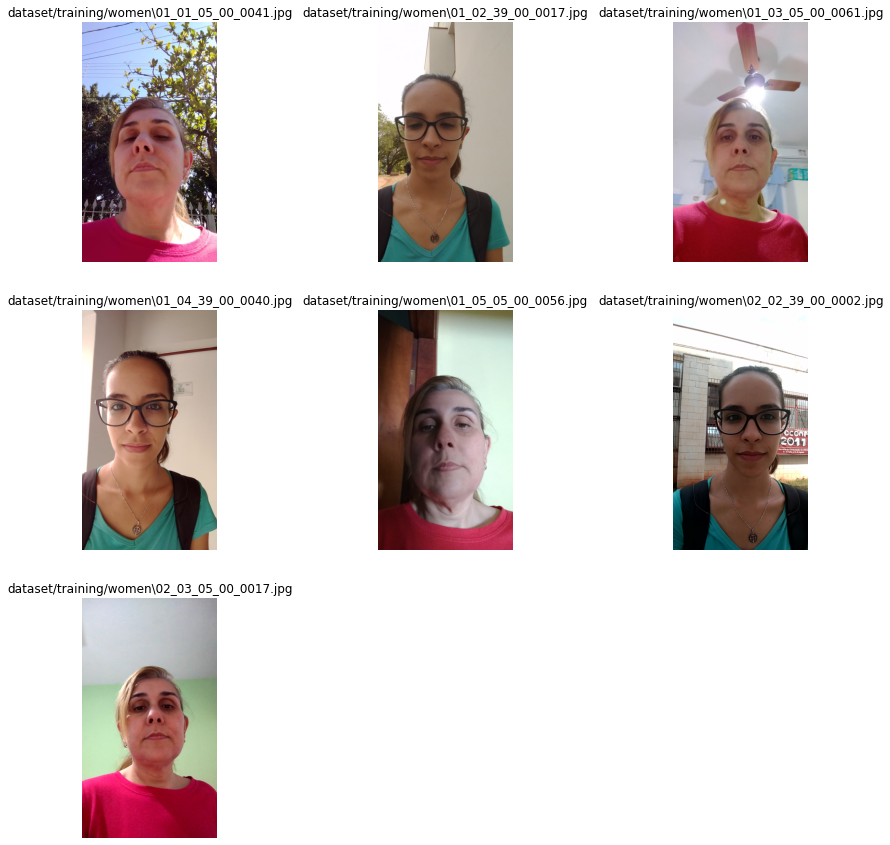

In [162]:
# Displaying images that Haar Cascade couldn't detect faces of.
print("\nDisplaying images with no detected faces:")

num_columns = 3  #set the column size of grid
num_images = len(undetected_image)
num_rows = (num_images + num_columns - 1) // num_columns

# Create a subplot grid
fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))

# Flatten the subplot grid for easier indexing
axs = axs.flatten()

for i, image_path in enumerate(undetected_image):
    img = mpimg.imread(image_path)
    axs[i].imshow(img)
    axs[i].set_title(image_path)
    axs[i].axis('off')

# Hide any empty subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.show()


## Inference from women face data extraction/preparation

1. Out of 100 images, it successfully detected faces in 93 images, only leaving 7 images undetected by HaarCascade. 
3. Under close inspection, we can see from the above grid that the images that Haar Cascade could not identify as faces are those images which either have a very bright contrast, background texture completey blown out, or images which are not separate from the background, or low-light images, or those where the face overlaps with the edges of the image (i.e., face not in the middle).

 Therefore including them would not make our later process better so in this case it is safe to drop these 7 images!!

### Finally Total images ready for the next steps:
#### Total Men images = 94
#### Total Women images = 93

# Task A.2 Data Preparation (Preparing final Dataset)

In [17]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [76]:
##############  SCRIPT TO SPLIT THE DATASET INTO TRAINING AND VALIDATION (JUST CHANGE THE SOURCE AND DESTINATION PATH to move files!!)
## The image data from the above step is in the folder called "extracted".... now this shell sends the images to "updated_dataset" folder
import os
import shutil
import random

source_folder = "extracted/women/"
destination_folder = "updated_dataset/validation/women/"
percentage_to_move = 0.3

all_files = os.listdir(source_folder)
files_to_move = random.sample(all_files, int(len(all_files) * percentage_to_move))


for file_name in files_to_move:
    source_path = os.path.join(source_folder, file_name)
    destination_path = os.path.join(destination_folder, file_name)
    shutil.move(source_path, destination_path)
   

## Data Preprocessing (Data Augmentation)

Since we have a very few data to build a CNN model to classify images, here `Data Augmentation` technique is used on the training data. Data Augmentation basically increases the number of examples in the training set. Here multiple forms of each image are generated, which can help the CNN model to generalize the face images much better.

Note: Data augmentation is only applied to the training set to artificially expand the size and diversity of the training data. This helps the model learn more robust and generalize better to unseen data. Applying data augmentation to the validation set or test set is not recommended, as it can introduce artificial biases and inflate the model's performance on these datasets !!!

In [33]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
       
)

In [34]:
val_datagen = ImageDataGenerator(rescale=1./255)  # No data augmentation for validation

In [35]:
# train generator
train_generator = train_datagen.flow_from_directory(
    'updated_dataset/training/',
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical',
    # class_mode='binary',
    subset='training',  # Specify this is for training
    shuffle=True,
    seed=42
)

Found 132 images belonging to 2 classes.


In [36]:
train_generator.class_indices

{'men': 0, 'women': 1}

In [37]:
# validation generator
validation_generator = val_datagen.flow_from_directory(
    'updated_dataset/validation/',
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary',
    shuffle=True,
    seed=42
)

Found 55 images belonging to 2 classes.


# Building a CNN model architecture

In [220]:
# Creating a CNN model

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))   #  first convolution layer with 32 filters of size 3x3
model.add(layers.MaxPooling2D((2, 2)))  

model.add(layers.Conv2D(64, (3, 3), activation='relu'))  # second covolution layer 
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))  # third convolution layer
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())   #flatten layer ----> flattens the output from previous layers into a one-dimensional vector

model.add(layers.Dense(128, activation='relu'))   # fully connected dense layers 
# model.add(layers.Dense(1, activation='sigmoid'))
model.add(layers.Dense(2, activation='softmax'))



<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x00000254135C6970>>

In [5]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_55 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 14, 14, 128)    

In [221]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


### To visualize the CNN model

In [50]:
from keras_visualizer import visualizer

visualizer(model, file_format='png', view=True)

## Training the Neural Network

In [189]:
# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)

Epoch 1/20
9/9 [==============================] - 3s 257ms/step - loss: 0.7593 - accuracy: 0.4848 - val_loss: 0.6727 - val_accuracy: 0.7636
Epoch 2/20
9/9 [==============================] - 2s 236ms/step - loss: 0.6726 - accuracy: 0.5530 - val_loss: 0.6298 - val_accuracy: 0.7273
Epoch 3/20
9/9 [==============================] - 2s 240ms/step - loss: 0.6405 - accuracy: 0.6818 - val_loss: 0.5169 - val_accuracy: 0.7455
Epoch 4/20
9/9 [==============================] - 2s 240ms/step - loss: 0.5297 - accuracy: 0.7424 - val_loss: 0.4748 - val_accuracy: 0.8182
Epoch 5/20
9/9 [==============================] - 2s 238ms/step - loss: 0.4521 - accuracy: 0.8106 - val_loss: 0.4420 - val_accuracy: 0.8182
Epoch 6/20
9/9 [==============================] - 2s 248ms/step - loss: 0.5141 - accuracy: 0.7727 - val_loss: 0.4687 - val_accuracy: 0.7636
Epoch 7/20
9/9 [==============================] - 2s 246ms/step - loss: 0.4793 - accuracy: 0.8182 - val_loss: 0.4201 - val_accuracy: 0.8364
Epoch 8/20
9/9 [====

## Model Evaluation 

In [193]:

from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

In [229]:
# Evaluate the model on the validation set
validation_loss, validation_accuracy = model.evaluate(validation_generator)

# Predictions on the validation set
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
true_classes = validation_generator.classes   # to retrieve true labels for the validation sets from the generator

# Classification Report
print("Classification Report:")
print(classification_report(true_classes, y_pred_classes))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(true_classes, y_pred_classes))

# Print the validation accuracy
print(f"Validation Accuracy: {validation_accuracy}")



4/4 [==============================] - 0s 41ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.64      0.63        28
           1       0.62      0.59      0.60        27

    accuracy                           0.62        55
   macro avg       0.62      0.62      0.62        55
weighted avg       0.62      0.62      0.62        55


Confusion Matrix:
[[18 10]
 [11 16]]
Validation Accuracy: 0.8363636136054993


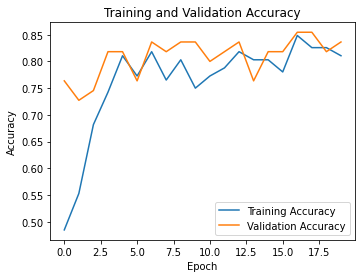

In [191]:
# Plot training and validation accuracy 
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

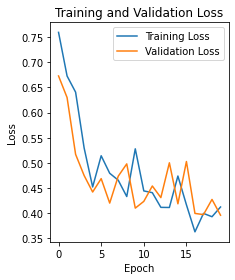

In [192]:
# Plot training and validation loss 
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Save the Model !!

In [223]:
# save the model 
model.save("image_classification_model.h5")

# Dummy Prediction

Here I used some images that were not in the training or validation sets, to confirm whether the model works for real life image data or not.
The data used in these dummy prediction are present inside the folder called `testing_dataset`.

1/1 [==============================] - 0s 80ms/step


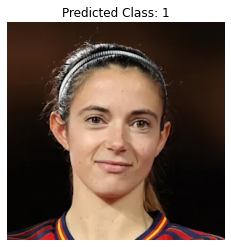

In [22]:
import numpy as np
from tensorflow.keras.models import load_model

model = load_model("image_classification_model.h5")  # Loading the saved model

# Function to preprocess the image and extract the face using Haar Cascade
def preprocess_and_extract_face(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #  Haar Cascade to detect faces
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    if len(faces) > 0:
        # Assume the first detected face is the primary face
        x, y, w, h = faces[0]
        face_img = img[y:y+h, x:x+w]
        face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
        face_img = cv2.resize(face_img, (128, 128))
        face_img = face_img / 255.0
        return face_img.reshape(1, 128, 128, 3)
    else:
        # If no face is detected, return None
        return None

# Path to the real-life image (images are inside testing_dataset)
test_image_path = "testing_dataset/bonmati.jpg"

# Load the original image
original_image = cv2.imread(test_image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Preprocess and extract the face from the image
input_image = preprocess_and_extract_face(test_image_path)

if input_image is not None:
    # Make a prediction
    predictions = model.predict(input_image)

    # Get the predicted class
    predicted_class = np.argmax(predictions)

    # Print the predicted class (0 for men, 1 for women)
    # print(f"Predicted Class: {predicted_class}")

    plt.imshow(original_image)
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')  # Turn off axis labels for better visualization
    plt.show()
else:
    print("No face detected in the input image.")


# Verdict from this Model !!!!!!


The results from the dummy predictions confirmed the effectiveness of the model,
demonstrating its capability to classify real-life images accurately. 
The successful execution of the dummy predictions serves as a practical validation, affirming the model's functionality beyond theoretical metrics obtained from the confusion matrix.


For experimenation purpose, lets use a pre-trained CNN model to check how it does with our usecase !!!

# Approach 2: Using a pre-trained CNN model (using pre-trained VGG16 MODEL)

## Just for experimentation purpose !!

In [38]:
from tensorflow.keras.applications import VGG16

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

In [40]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [41]:
val_datagen = ImageDataGenerator(rescale=1./255)  # No data augmentation for validation

In [42]:
# train generator
train_generator = train_datagen.flow_from_directory(
    'updated_dataset/training/',
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary',
    subset='training',  # Specify this is for training
    shuffle=True,
    seed=42
)

Found 132 images belonging to 2 classes.


In [43]:
# validation generator
validation_generator = val_datagen.flow_from_directory(
    'updated_dataset/validation/',
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary',
    shuffle=True,
    seed=42
)

Found 55 images belonging to 2 classes.


In [44]:
# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

In [45]:
# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

In [46]:
# Create a new model on top of the VGG16 base
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [47]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,  # Adjust the number of epochs
    validation_data=validation_generator
)

Epoch 1/10
9/9 [==============================] - 11s 1s/step - loss: 1.0453 - accuracy: 0.5455 - val_loss: 0.4558 - val_accuracy: 0.8182
Epoch 2/10
9/9 [==============================] - 9s 1s/step - loss: 0.8160 - accuracy: 0.6288 - val_loss: 0.3789 - val_accuracy: 0.8727
Epoch 3/10
9/9 [==============================] - 9s 1s/step - loss: 0.6232 - accuracy: 0.7045 - val_loss: 0.6512 - val_accuracy: 0.6545
Epoch 4/10
9/9 [==============================] - 9s 1s/step - loss: 0.5880 - accuracy: 0.7273 - val_loss: 0.4716 - val_accuracy: 0.7818
Epoch 5/10
9/9 [==============================] - 9s 1s/step - loss: 0.4128 - accuracy: 0.8561 - val_loss: 0.3064 - val_accuracy: 0.8545
Epoch 6/10
9/9 [==============================] - 10s 1s/step - loss: 0.4837 - accuracy: 0.7803 - val_loss: 0.3633 - val_accuracy: 0.8364
Epoch 7/10
9/9 [==============================] - 10s 1s/step - loss: 0.4735 - accuracy: 0.7727 - val_loss: 0.3253 - val_accuracy: 0.8545
Epoch 8/10
9/9 [======================

In [48]:
# Evaluate the model on the validation set
validation_loss, validation_accuracy = model.evaluate(validation_generator)

# Predictions on the validation set
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
true_classes = validation_generator.classes   # to retrieve true labels for the validation sets from the generator

# Classification Report
print("Classification Report:")
print(classification_report(true_classes, y_pred_classes))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(true_classes, y_pred_classes))

# Print the validation accuracy
print(f"Validation Accuracy: {validation_accuracy}")

4/4 [==============================] - 3s 687ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.51      1.00      0.67        28
           1       0.00      0.00      0.00        27

    accuracy                           0.51        55
   macro avg       0.25      0.50      0.34        55
weighted avg       0.26      0.51      0.34        55


Confusion Matrix:
[[28  0]
 [27  0]]
Validation Accuracy: 0.9090909361839294


c:\Users\Adarsha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Adarsha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Adarsha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

# Verdict from this model

The myth that pre-trained models consistently outperform custom models is challenged by the observed limitations in the VGG16-based approach for this specific facial image classification task. This model struggled to adapt to the unique features of the dataset, leading to suboptimal classification results, as evident from the confusion matrix !!!!